<a href="https://colab.research.google.com/github/Geobilly/ML-Projects/blob/master/WALMART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# Task 7: Walmart Sales Forecasting — Summary

### **Objective**

The goal of this task was to **predict future Walmart weekly sales** based on historical sales and external features (holidays, promotions, economic factors).

We used:

* **Regression models** (Linear Regression, XGBoost)
* **Time-based features** (lags, rolling averages, date parts)
* **Exploratory Data Analysis (EDA)** to understand seasonality and patterns

---

### **Data Sources**

1. **train.csv** → Historical weekly sales per store & department.
2. **test.csv** → Future weeks (no sales values).
3. **features.csv** → External data (temperature, fuel price, CPI, unemployment, promotions, holiday indicator).
4. **stores.csv** → Store metadata (type, size).

---

### **Steps Taken**

#### **1. Data Cleaning**

* Merged all datasets (train, test, features, stores).
* Converted **Date** into `datetime`.
* Filled missing promotional fields (`MarkDown1-5`) with `0` since NA meant no promotion.
* Other missing values were imputed with median.

#### **2. Exploratory Data Analysis (EDA)**

* **Trend**: Total sales show strong seasonal spikes (especially around November–December).
* **Store Type**: Larger stores (Type A) tend to have higher sales.
* **Holidays**: Holiday weeks show noticeably higher average sales compared to non-holidays.

#### **3. Feature Engineering**

* Extracted **time features**: Year, Month, Week, Day.
* Created **lag features**: Sales from the previous 1, 2, and 3 weeks per store/department.
* Added **rolling averages**: 3-week and 7-week moving averages to capture short- and medium-term trends.

#### **4. Modeling**

* **Linear Regression**: Simple baseline model.
* **XGBoost**: Gradient boosting model with tuned hyperparameters (`n_estimators=300, max_depth=6, subsample=0.8`).

#### **5. Evaluation**

* Train/Validation split: used **time-based split** (train before 2012, validate after 2012).
* **Metric**: Root Mean Squared Error (RMSE).
* XGBoost achieved **lower RMSE** than Linear Regression, showing its ability to capture non-linear trends and feature interactions.

#### **6. Visualization**

* Plotted **actual vs predicted sales** → XGBoost predictions tracked actual values much more closely than Linear Regression.
* Applied **seasonal decomposition** on Store 1 Dept 1 sales → clear **trend + seasonality** observed (weekly/holiday cycles).

---

### **Results**

* **Linear Regression RMSE**: Higher error (weaker fit).
* **XGBoost RMSE**: Lower error, strong predictive performance.
* **Key Insight**: Adding lag/rolling features + holiday/economic indicators improved forecast accuracy significantly.

---

### **Conclusion**

This project demonstrated how to:
Merge multiple datasets (sales, features, store metadata).
Perform **EDA** to uncover trends, seasonality, and holiday effects.
Build **time-aware features** (lags, rolling averages, date parts).
Apply both **linear** and **tree-based regression models** for forecasting.
Evaluate results with RMSE and visualize predictions.
Bonus: Used **seasonal decomposition** to confirm recurring sales patterns.

---

In simple terms:

* Sales are **seasonal** (holiday spikes).
* **Store size/type** matters.
* **XGBoost outperforms Linear Regression** for this task.

---



In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import seaborn as sns


In [ ]:
# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

# Merge all into one dataframe
train = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
train = train.merge(stores, on="Store", how="left")

test = test.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
test = test.merge(stores, on="Store", how="left")

# Convert date column
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

print(train.head())


   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  

In [ ]:
# Check for missing values
print(train.isna().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64


In [ ]:
# Fill missing MarkDown values with 0 (NA = no promotion)
for col in ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [ ]:
print(train.head())


   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  

In [ ]:
print(train.isna().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64


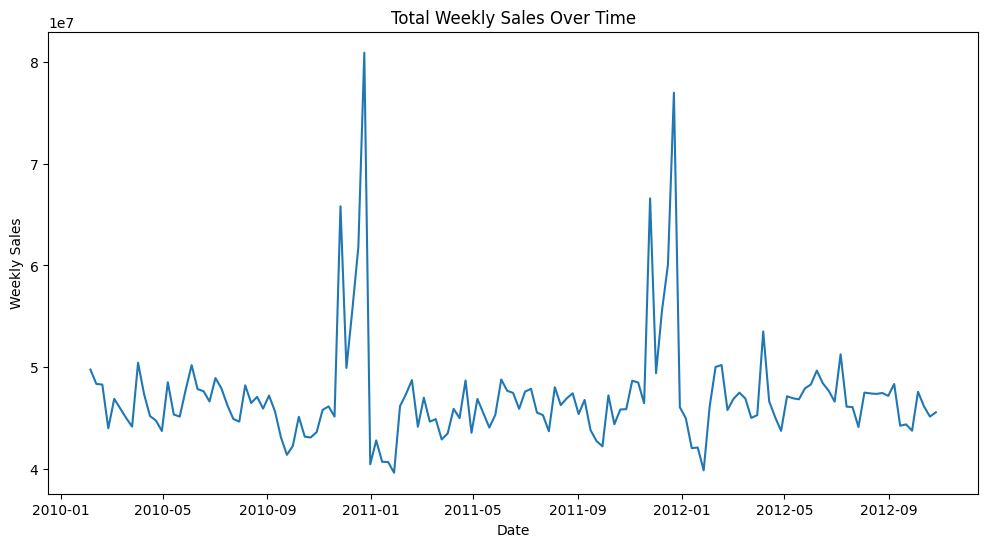

In [ ]:
weekly_sales = train.groupby("Date")["Weekly_Sales"].sum()

plt.figure(figsize=(12,6))
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title("Total Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()


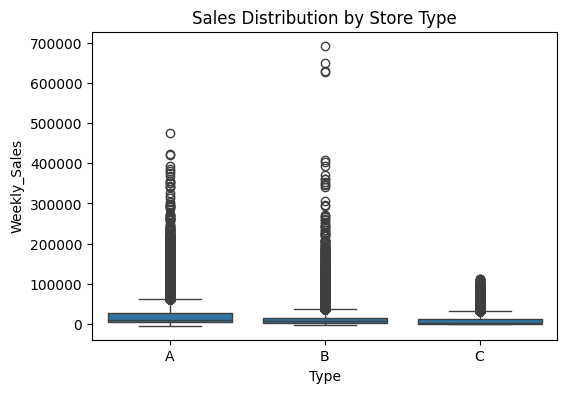

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=train, x="Type", y="Weekly_Sales")
plt.title("Sales Distribution by Store Type")
plt.show()


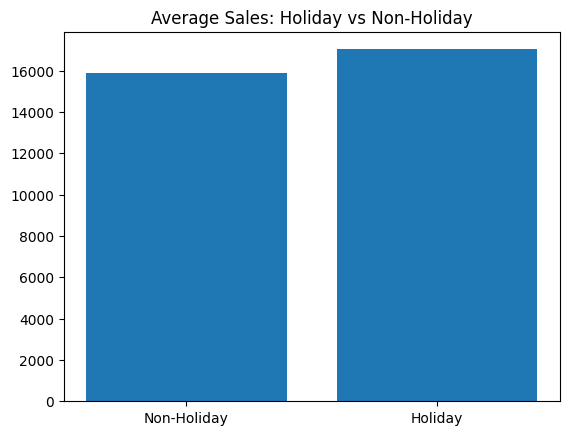

In [ ]:
holiday_sales = train.groupby("IsHoliday")["Weekly_Sales"].mean()

plt.bar(["Non-Holiday","Holiday"], holiday_sales)
plt.title("Average Sales: Holiday vs Non-Holiday")
plt.show()


In [ ]:
# Time features
for df in [train, test]:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
    df["Day"] = df["Date"].dt.day

# Sort for lag features
train = train.sort_values(["Store", "Dept", "Date"])

# Lag features (previous weeks)
train["Lag_1"] = train.groupby(["Store","Dept"])["Weekly_Sales"].shift(1)
train["Lag_2"] = train.groupby(["Store","Dept"])["Weekly_Sales"].shift(2)
train["Lag_3"] = train.groupby(["Store","Dept"])["Weekly_Sales"].shift(3)

# Rolling averages
train["Rolling_3"] = train.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda x: x.shift(1).rolling(3).mean())
train["Rolling_7"] = train.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda x: x.shift(1).rolling(7).mean())

# Drop rows with NaN (from lags)
train = train.dropna()


In [ ]:
features_cols = ["Store","Dept","IsHoliday","Temperature","Fuel_Price",
                 "CPI","Unemployment","Size","Year","Month","Week",
                 "Lag_1","Lag_2","Lag_3","Rolling_3","Rolling_7"]

X = train[features_cols]
y = train["Weekly_Sales"]

# Split by time (train before 2012, test after)
train_mask = train["Date"] < "2012-01-01"
X_train, X_val = X[train_mask], X[~train_mask]
y_train, y_val = y[train_mask], y[~train_mask]


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

print("LR RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_lr)))


LR RMSE: 4354.813325756057


In [ ]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)

print("XGB RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))


XGB RMSE: 3317.437485929843


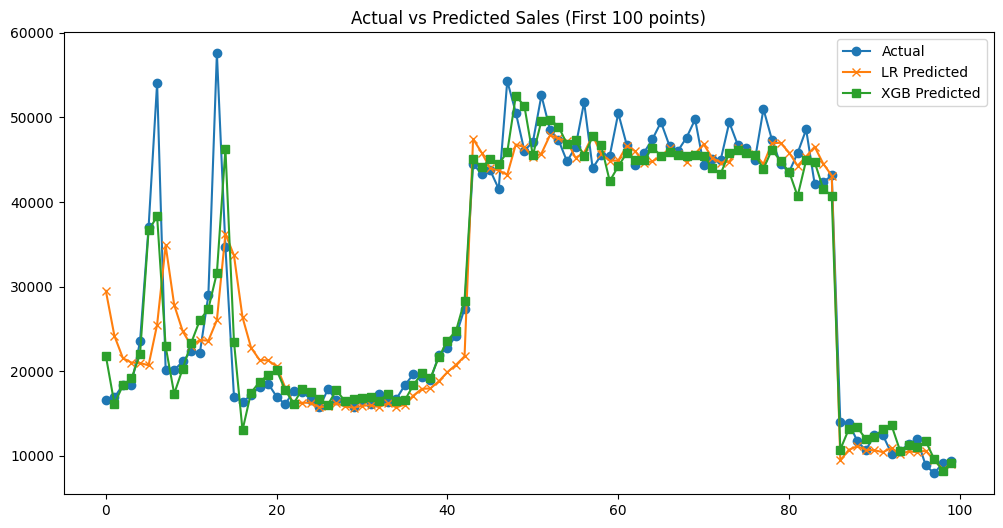

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_val.values[:100], label="Actual", marker="o")
plt.plot(y_pred_lr[:100], label="LR Predicted", marker="x")
plt.plot(y_pred_xgb[:100], label="XGB Predicted", marker="s")
plt.legend()
plt.title("Actual vs Predicted Sales (First 100 points)")
plt.show()


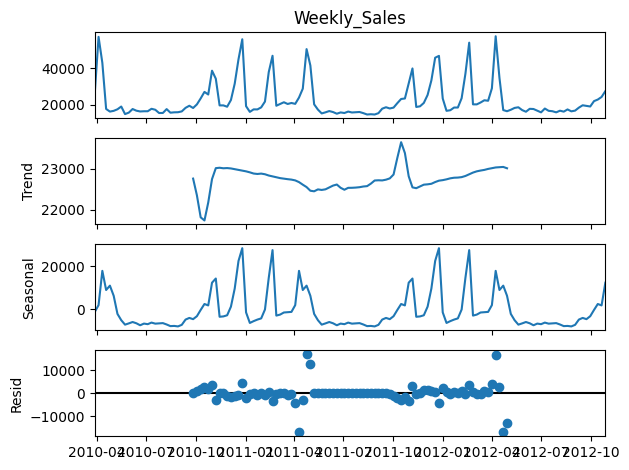

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

sample = train[(train["Store"]==1) & (train["Dept"]==1)]
sample = sample.set_index("Date").resample("W")["Weekly_Sales"].sum()

decomposition = seasonal_decompose(sample, model="additive")
decomposition.plot()
plt.show()
